# Sentiment Analysis

We thought that it would be interesting to conduct a sentiment analysis for the Naruto series. The sentiment scores of the episodes didn't end up in our research paper, but the analysis is presented in this notebook. 

## Sentiment Analysis of Each Episode

First of, we start by important the neccesary packages:

In [32]:
from nltk.tokenize import word_tokenize
import json
import matplotlib.pyplot as plt

Then, the data is loaded in for the processing part:

In [30]:
json_file_path_episode_dict = '/Users/lukasjonsson/Desktop/DTU/Kandidat/3. semester/Social graphs & interactions/Project/socialGraphsProject/data/episodes_seasons_with_text.json'

with open(json_file_path_episode_dict, 'r') as file:
    episode_dict = json.load(file)

We use the LabMT wordlist to assign each word a value:

In [22]:
def load_labmt_wordlist(file_path):
    """
    Load LabMT wordlist from a given file.

    Parameters:
    - file_path (str): The path to the LabMT wordlist file.

    Returns:
    - word_scores (dict): A dictionary where keys are words and values are corresponding sentiment scores.

    """
    word_scores = {}  
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:  
            parts = line.strip().split('\t')
            if len(parts) >= 3 and parts[0] != "word":  
                word = parts[0]
                score = float(parts[2]) if parts[2] != '--' else 5.0
                word_scores[word] = score
    return word_scores

labmt_wordlist_file = '/Users/lukasjonsson/Desktop/DTU/Kandidat/3. semester/Social graphs & interactions/Project/socialGraphsProject/LabMT_wordlist.txt'  # Name has been anonymized
labmt = load_labmt_wordlist(labmt_wordlist_file)


From here, the sentiment score for each episode is computed:

In [31]:
sentiment_scores_episodes = {}

def calculate_sentiment(description, word_scores):
    """
    Calculate the sentiment score for a given text description.

    Parameters:
    - description (str): The text description for which sentiment is to be calculated.
    - word_scores (dict): A dictionary containing word sentiment scores.

    Returns:
    - float or None: The average sentiment score if valid tokens are found, otherwise None.

    """
    if description is None:
        return None
    
    tokens = word_tokenize(description.lower())
    sentiment_scores_episodes = [word_scores.get(token, 0) for token in tokens]
    
    if sentiment_scores_episodes:
        average_sentiment = sum(sentiment_scores_episodes) / len(sentiment_scores_episodes)
        return average_sentiment
    else:
        return None

all_sentiment_scores = []
for arc_name, episodes in episode_dict.items():
    for episode in episodes:
        episode_title = episode['Episode Title']
        episode_description = episode.get('episode synopsis text', '')

        sentiment_score = calculate_sentiment(episode_description, labmt)
        
        episode['sentiment_score'] = sentiment_score

        sentiment_scores_episodes.setdefault(arc_name, []).append({'Episode Title': episode_title, 'Sentiment Score': sentiment_score})

        if sentiment_score is not None:
            all_sentiment_scores.append(sentiment_score)

average_sentiment_all_episodes = sum(all_sentiment_scores) / len(all_sentiment_scores)

for arc_name, episodes in sentiment_scores_episodes.items():
    for episode in episodes:
        if episode['Sentiment Score'] is None:
            episode['Sentiment Score'] = average_sentiment_all_episodes

for arc_name, episodes in sentiment_scores_episodes.items():
    print(f"Arc: {arc_name}")
    for episode in episodes:
        print(f"Episode: {episode['Episode Title']}, Sentiment Score: {episode['Sentiment Score']}")

with open('../data/sentiment_scores_episodes.json', 'w') as file:
    json.dump(sentiment_scores_episodes, file)


Arc: Naruto: Original
Episode: Enter:_Naruto_Uzumaki!, Sentiment Score: 3.7407368421052687
Episode: My_Name_is_Konohamaru!, Sentiment Score: 3.6494961240310126
Episode: Sasuke_and_Sakura:_Friends_or_Foes?, Sentiment Score: 3.9311638591117877
Episode: Pass_or_Fail:_Survival_Test, Sentiment Score: 3.8157432432432428
Episode: You_Failed!_Kakashi's_Final_Decision, Sentiment Score: 3.863647058823526
Episode: A_Dangerous_Mission!_Journey_to_the_Land_of_Waves!, Sentiment Score: 3.7532543443917863
Episode: The_Assassin_of_the_Mist!, Sentiment Score: 3.5386159169550178
Episode: The_Oath_of_Pain, Sentiment Score: 3.355276381909547
Episode: Kakashi:_Sharingan_Warrior!, Sentiment Score: 3.6500000000000004
Episode: The_Forest_of_Chakra, Sentiment Score: 3.664071856287428
Episode: The_Land_Where_a_Hero_Once_Lived, Sentiment Score: 4.179662162162165
Episode: Battle_on_the_Bridge!_Zabuza_Returns!, Sentiment Score: 3.7863025210084054
Episode: Haku's_Secret_Jutsu:_Demonic_Mirroring_Ice_Crystals, Sentime

We wanted to see if any pattern could be found by computing the sentiment score for each episode and plotting it. Maybe there would be a more positive or negative development in the series as it went along? Or maybe it would take the properties of a noise graph where it is difficult to really conclude anything from it.

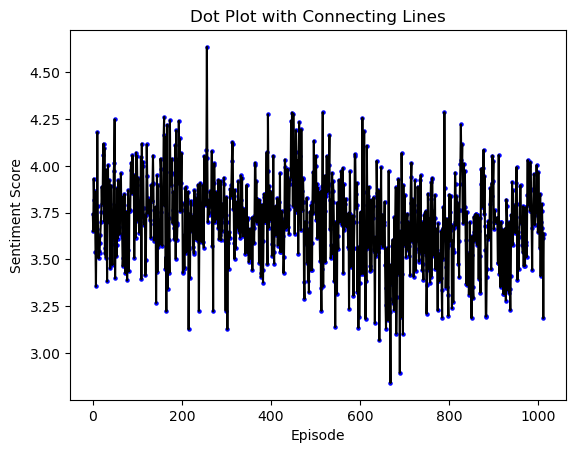

In [33]:
y_values = []

for arc_name, episodes in sentiment_scores_episodes.items():
    for episode in episodes:
        y_values.append(episode['Sentiment Score'])

plt.scatter(range(len(y_values)), y_values, label='Episodes', color='blue', s=5)

plt.plot(range(len(y_values)), y_values, linestyle='-', marker='', color='black')

plt.title('Dot Plot with Connecting Lines')
plt.xlabel('Episode')
plt.ylabel('Sentiment Score')

plt.show()

As the plot above shows, it has the same characteristics as a noise graph. It is difficult to really conclude something by this analysis. But maybe this could be expected. For a series consisting of over 1000 episodes, it would be natural that the episodes would be a mix between some more 'positive' oriented and some would be more 'negative'. Another thing worth noticing is that the episodes really don't differ that much in terms of absolute difference. In generel, the episodes has a pretty low sentiment scores which makes sense considering the nature of the series, which is about ninjas fighting each other.

## Character Sentiment Analysis

Another aspect we wanted to dive into was the character sentiment scores. Could we find some evil characters and some good characters? Therefore, we computed their sentiment scores and added their sentiment score as an attribute.

First off, we start by importing the text data for each character:

In [13]:
json_file_path_characther_text = '/Users/lukasjonsson/Desktop/DTU/Kandidat/3. semester/Social graphs & interactions/Project/socialGraphsProject/data/characters_texts.json'

with open(json_file_path_characther_text, 'r') as file:
    characters_text = json.load(file)

From here, we can now begin to calculate the sentiment score of each character in a similar way to how we did it for each episode:

In [34]:
sentiment_scores_characters = {}

def calculate_sentiment(description, word_scores):
    """
    Calculate the sentiment score for each character given their text description.

    Parameters:
    - description (str or list): The text description for each character for which sentiment is to be calculated. Can be a string or a list of strings.
    - word_scores (dict): A dictionary containing word sentiment scores.

    Returns:
    - float or None: The average sentiment score if valid tokens are found, otherwise None.

    """
    description_str = ' '.join(description) if isinstance(description, list) else str(description)
    
    tokens = word_tokenize(description_str.lower())
    
    sentiment_scores_characters = [word_scores.get(token, 0) for token in tokens]
    
    if sentiment_scores_characters:
        average_sentiment = sum(sentiment_scores_characters) / len(sentiment_scores_characters)
        return average_sentiment
    else:
        return None

for character_name, combined_description in characters_text.items():
    sentiment_scores_characters[character_name] = calculate_sentiment(combined_description, labmt)

for character_name, score in sentiment_scores_characters.items():
    print(f"Character: {character_name}, Sentiment Score: {score}")

with open('../data/sentiment_scores_characters.json', 'w') as file:
    json.dump(sentiment_scores_characters, file)


Character: Akane, Sentiment Score: 3.6959190031152667
Character: Akemaru, Sentiment Score: 3.6194999999999995
Character: Ada, Sentiment Score: 3.9541736227045052
Character: Agira_Ryūdōin, Sentiment Score: 3.8489215686274525
Character: Agari_Kaisen, Sentiment Score: 3.6490361445783135
Character: Aoda, Sentiment Score: 3.392766749379652
Character: Akaboshi, Sentiment Score: 3.6516870415647884
Character: Amachi, Sentiment Score: 3.7765217391304367
Character: Akari, Sentiment Score: 3.8690643274853826
Character: Akebi_Sanzu, Sentiment Score: 3.8466081871345064
Character: Akari_Tatsushiro, Sentiment Score: 4.011535353535359
Character: Amado_Sanzu, Sentiment Score: 3.810792682926815
Character: Ajisai, Sentiment Score: 3.8323349339735744
Character: Ameyuki, Sentiment Score: 3.712694736842102
Character: Ameno, Sentiment Score: 3.9062939698492447
Character: Anko_Mitarashi, Sentiment Score: 3.7079616671736924
Character: Anbu_Commander, Sentiment Score: 3.6460428849902566
Character: Anaguma, Sent

Let's have a look at the most positive and negative characters of the series:

In [50]:
max_key = max(sentiment_scores_characters, key=sentiment_scores_characters.get)
max_value = sentiment_scores_characters[max_key]
min_key = min(sentiment_scores_characters, key=sentiment_scores_characters.get)
min_value = sentiment_scores_characters[min_key]

print('Most positive character:', max_key, 'with a score of:', max_value)
print('Most negative character:', min_key, 'with a score of:', min_value)

Most positive character: Sound_Daimyō with a score of: 4.682298850574713
Most negative character: Zetsu with a score of: 2.4963636363636366
